# Werkcollege 9 - Robotarm team 2

In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Video
%matplotlib inline

from motion_detection_utils import *

In [3]:
# data_path = 'images'
data_path = 'images_highway'
image_paths = []
for image_name in os.listdir(data_path):
    if '.jpg' in image_name:
        image_paths.append(f'{data_path}/{image_name}')

## Motion Mask - Optical Flow

In [5]:
video_frames = []

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    flow = compute_flow(frame1_bgr, frame2_bgr)

    # separate into magntiude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    rgb = get_flow_viz(flow)
    motion_thresh = np.c_[np.linspace(1e-6, 3e-2, 1080)].repeat(1920, axis=-1)
    mask = get_motion_mask(mag/mag.max(), motion_thresh=motion_thresh)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(mask)
    plt.axis('off')
    # fig.savefig(f"motion_mask_of/frame_{idx}.png")
    plt.close()

    # OPTIONAL append to list for video
    video_frames.append(mask)

In [7]:
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter('optical_flow_highway.mp4', fourcc, 25, (1920, 1080))

for img in video_frames:
    out.write(img)

out.release()
del out

In [ ]:
Video("optical_flow_highway.mp4", embed=True, width=800)

## Motion Mask - Frame Differencing

In [8]:
video_frames = []

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    img1 = cv2.cvtColor(frame1_bgr, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(frame2_bgr, cv2.COLOR_RGB2GRAY)

    kernel = np.array((9,9), dtype=np.uint8)
    mask = get_mask(img1, img2, kernel)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(mask)
    plt.axis('off')
    # fig.savefig(f"motion_mask_of/frame_{idx}.png")
    plt.close()

    # OPTIONAL append to list for video
    video_frames.append(mask)

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter('frame_differencing_highway.mp4', fourcc, 25, (1920, 1080))

for img in video_frames:
    out.write(img)

out.release()
del out

In [ ]:
Video("frame_differencing_highway.mp4", embed=True, width=800)

# Verschil tussen Optical Flow & Frame Differencing

## Frame Differencing:
* Verschil tussen 2 frames
* Speckles (Noise van afbeelding of camera beweging)
* Threshold
* Schaduw

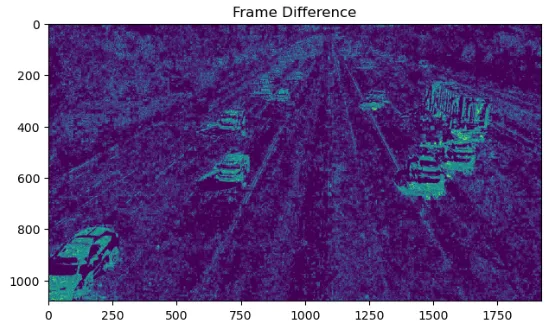
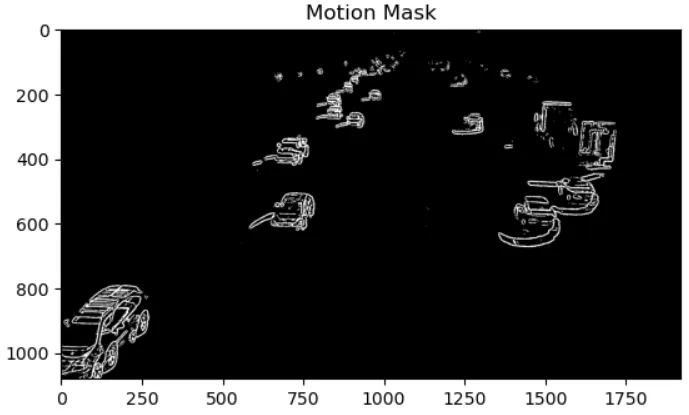

## Optical Flow:
* Verschil tussen 2 frames
* Motion Vectors (Hoe bewegen de pixels?)
* Vector field (Snelheid en richting van de pixels)

# Background Subtraction

In [4]:
video_frames = []

kernel=np.array((9,9), dtype=np.uint8)

sub_type = 'KNN' # 'MOG2' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

for idx in range(0, len(image_paths)):
    # read frames
    frame_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections_bgr(backSub, 
                                frame_bgr, # cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=100, 
                                nms_thresh=1e-2, 
                                kernel=kernel)
                                
    # draw bounding boxes on frame
    draw_bboxes(frame_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame_bgr)
    plt.axis('off')
    # fig.savefig(f"temp/frame_{idx}.png")
    plt.close()

    # OPTIONAL append to list for video
    video_frames.append(frame_bgr)

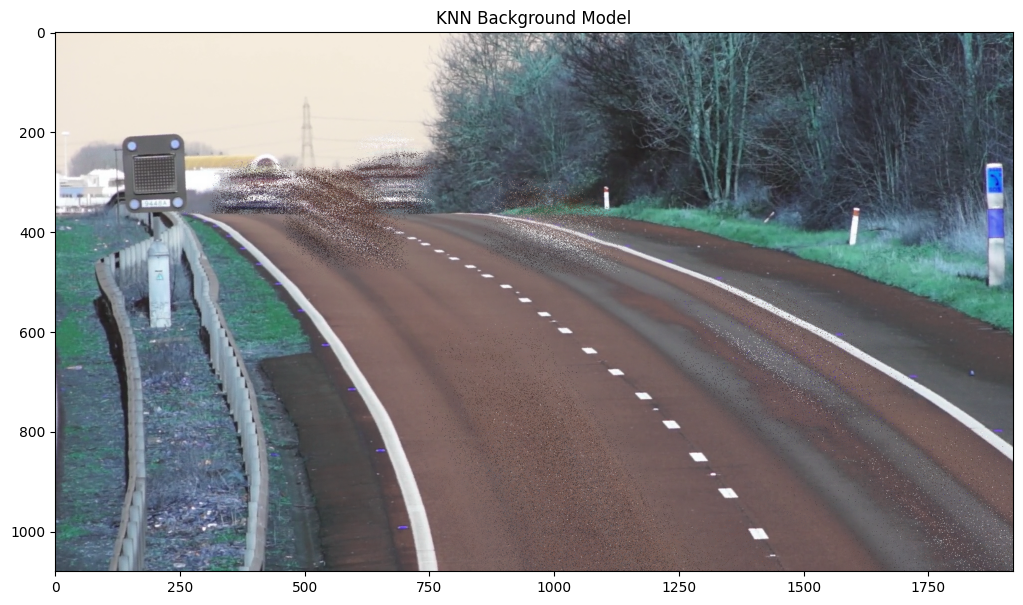

In [5]:
knn_background = backSub.getBackgroundImage()
plt.figure(figsize=(15, 7))

plt.imshow(knn_background) 
plt.title(f"KNN Background Model")
plt.show()